In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
!pip install jours-feries-france
from jours_feries_france import JoursFeries


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\lisag\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import requests as rq 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.linear_model import LinearRegression
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn import metrics


# accès aux données : https://odre.opendatasoft.com/explore/dataset/eco2mix-national-cons-def/information

# dates de début et de fin de la plage de données, format AAAA-MM-JJ
date_debut = '2012-01-01'
date_fin = '2022-12-31'

# variables :
# perimetre ; nature ; date ; heure ; date_heure ;
# consommation ; prevision_j1 ; prevision_j ; fioul ; charbon ;
# gaz ; nucleaire ; eolien ; solaire ; hydraulique ;
# pompage ; bioenergies ; ech_physiques ; taux_co2 ; ech_comm_angleterre ;
# ech_comm_espagne ; ech_comm_italie ; ech_comm_suisse ; ech_comm_allemagne_belgique ; fioul_tac ;
# fioul_cogen ; fioul_autres ; gaz_tac ; gaz_cogen ; gaz_ccg ;
# gaz_autres ; hydraulique_fil_eau_eclusee ; hydraulique_lacs ; hydraulique_step_turbinage ; bioenergies_dechets ;
# bioenergies_biomasse ; bioenergies_biogaz

df_cons = pd.read_csv(r"eco2mix-national-cons-def.csv", sep=';')
# toutes les consommations sont en MW
#df_cons = df_cons[["Date", "Heure","Consommation"]].rename(mapper = {"Date" : "date","Heure" : "heure","Consommation" : "consommation"}, axis = 1)

C:\Users\lisag\AppData\Local\Temp\ipykernel_8864\2783197317.py:27: DtypeWarning: Columns (23,28) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cons = pd.read_csv(r"eco2mix-national-cons-def.csv", sep=';')


In [56]:
df_cons

,date,heure,consommation,prevision_j1,date_heure
0,2012-01-01,00:00,58315.0,58200,2012-01-01 00:00:00
1,2012-01-01,00:30,58315.0,57200,2012-01-01 00:30:00
2,2012-01-01,01:00,56231.0,55200,2012-01-01 01:00:00
3,2012-01-01,01:30,56075.0,56000,2012-01-01 01:30:00
4,2012-01-01,02:00,55532.0,56000,2012-01-01 02:00:00
...,...,...,...,...,...
182587,2022-05-31,21:30,44043.0,43900,2022-05-31 21:30:00
182588,2022-05-31,22:00,44019.0,43700,2022-05-31 22:00:00
182589,2022-05-31,22:30,45067.0,44800,2022-05-31 22:30:00
182590,2022-05-31,23:00,46703.0,47100,2022-05-31 23:00:00


In [3]:
df_cons = df_cons[["date", "heure","consommation", "prevision_j1"]]

## I. Distribution des consommations électriques

In [4]:
mask = (df_cons['date'] >= date_debut) & (df_cons['date'] <= date_fin)
df_cons = df_cons.loc[mask]
df_cons.sort_values(["date","heure"], inplace=True)
# ajout d'une colonne avec les dates et les heures
df_cons['date_heure'] = pd.to_datetime(df_cons['date']+'T'+df_cons['heure'])
df_cons.dropna(axis = 0, inplace=True)
df_cons.reset_index(drop=True, inplace=True)


<AxesSubplot:xlabel='date'>

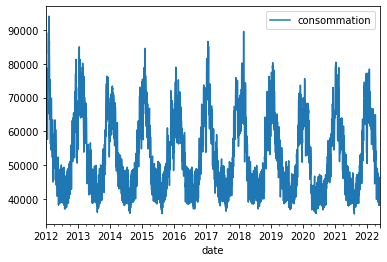

In [58]:
# calcul de la consommation moyenne par jour
cons_moy_quot = df_cons[['date_heure', 'consommation']] \
    .groupby(df_cons['date_heure'].dt.normalize().rename('date')) \
    .mean()
cons_moy_quot.plot()

In [59]:
cons_moy_quot

,consommation
date,
2012-01-01,51491.500000
2012-01-02,60683.645833
2012-01-03,67762.104167
2012-01-04,68029.229167
2012-01-05,69157.395833
...,...
2022-05-27,40620.354167
2022-05-28,38766.583333
2022-05-29,38017.583333


<AxesSubplot:xlabel='jour'>

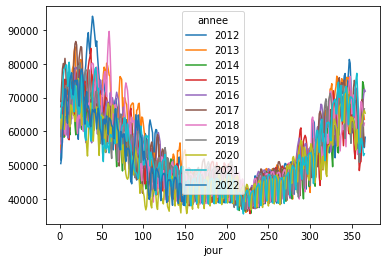

In [60]:
cons_moy_quot_ann = cons_moy_quot \
    .assign(annee=cons_moy_quot.index.year, jour=cons_moy_quot.index.dayofyear) \
    .pivot(index='jour', columns='annee', values='consommation')
cons_moy_quot_ann.plot()

## tendance gaussienne ? centrée au mois de décembre/janvier

### Rehearsal algorithm

In [7]:
# calcul de la consommation moyenne par jour
cons_moy_quot_est = df_cons[['prevision_j1']] \
    .groupby(df_cons['date_heure'].dt.normalize().rename('date')) \
    .mean()

In [8]:
# dataframe avec les consommations moyennes en MWh
df_cons_moy_quot = pd.DataFrame(columns = ["date","consommation_moy (MW)", "cons_reel"])
df_cons_moy_quot["date"] = cons_moy_quot_est.index
df_cons_moy_quot["consommation_moy (MW)"] = cons_moy_quot_est.values
df_cons_moy_quot["cons_reel"] = cons_moy_quot.values

In [9]:
# dataframe avec les consommations moyennes quotidiennes de 2015-2016
mask_15_16 = (df_cons_moy_quot['date'] >= "2015-09-01") & (df_cons_moy_quot['date'] <= "2016-08-31")
df_cons_15_16 = df_cons_moy_quot.loc[mask_15_16].reset_index(drop=True)
df_cons_15_16 
# il y a 365 jours
# en particulier il y a 300 jours bleus
# 43 jours blancs
# 22 jours rouges

,date,consommation_moy (MW),cons_reel
0,2015-09-01,48816.666667,47559.125000
1,2015-09-02,47466.666667,47104.104167
2,2015-09-03,46904.166667,47362.333333
3,2015-09-04,46760.416667,46868.166667
4,2015-09-05,41185.416667,41396.750000
...,...,...,...
361,2016-08-27,43504.166667,43248.312500
362,2016-08-28,40785.416667,39766.041667
363,2016-08-29,46331.250000,46517.875000
364,2016-08-30,48277.083333,47780.020833


In [10]:
# On prend le prix des heures pleines au kWH
p_bleu = 0.1249*24*1000
# HC: 0,097 €
p_blanc =  0.1508*24*1000
# HC: 0,114 €
p_rouge =  0.6712*24*1000
# HC: 0,1216 €

In [11]:
# ranger dans l'ordre décroissant les observations
df_cons_15_16.sort_values("consommation_moy (MW)", ascending=False, inplace=True)

In [12]:
df_cons_15_16.reset_index(drop=True,inplace=True)

In [29]:
# on choisit k = 43 + 22 = 65
import numpy as np 
from math import *
k = 65
top = round(k-2*np.sqrt(k))
bottom = round(2*np.sqrt(k))

In [30]:
list_threshold = [df_cons_15_16.loc[i, "consommation_moy (MW)"]  for i in range(top)] + [df_cons_15_16.loc[top-1, "consommation_moy (MW)"] for i in range(bottom)]

In [31]:
# dataframe avec les consommations moyennes quotidiennes de 2020-2021
mask_16_17 = (df_cons_moy_quot['date'] >= "2016-09-01") & (df_cons_moy_quot['date'] <= "2017-08-31")
df_cons_16_17 = df_cons_moy_quot.loc[mask_16_17].reset_index(drop=True)

def date_to_wd(tmstp) : #Fonction de transformation d'un timestamp en jour de la semaine
    dt = tmstp.date()
    return(dt.weekday())

def feries(tmstp) : #Fonction d'évaluation de si un jour est férié ou non
    return(JoursFeries.is_bank_holiday(tmstp.date(), zone="Métropole"))

df_cons_16_17['weekday'] = df_cons_16_17['date'].apply(date_to_wd)
df_cons_16_17['ferie'] = df_cons_16_17['date'].apply(feries)

In [32]:
list_threshold_copy = list_threshold.copy()

In [33]:
jours = []
conso = []
cons_reel =[] 
date = []
ferie = []
weekday = []
for i in range(len(df_cons_16_17)):
    if (df_cons_16_17.loc[i,'weekday'] in [6]):
        continue # on passe car pas de jours rouges/blancs les dimanches 
    store = []
    for j in range(len(list_threshold_copy)):
        if df_cons_16_17.loc[i,"consommation_moy (MW)"] > list_threshold_copy[j]:
            store.append(list_threshold_copy[j])
    if store:
        list_threshold_copy.remove(max(store))
        jours.append(i)
        conso.append(df_cons_16_17.loc[i,"consommation_moy (MW)"])
        cons_reel.append(df_cons_16_17.loc[i,"cons_reel"])
        date.append(df_cons_16_17.loc[i, "date"])
        ferie.append(df_cons_16_17.loc[i, "ferie"])
        weekday.append(df_cons_16_17.loc[i, "weekday"])



In [34]:
len(jours)

61

In [35]:
df = pd.DataFrame(columns=["jours","date","weekday", "ferie","conso", "cons_reel"])
df["jours"] = jours
df["date"] = date
df["conso"] = conso
df["weekday"] = weekday
df["ferie"] = ferie
df["cons_reel"] = cons_reel
df.sort_values("conso",ascending=False, inplace=True)


In [36]:
# on regarde si il y a des jours fériés dans la liste : si oui alors ce sera un jour blanc.
df[df["ferie"] == True]
# on regarde si il y a des samedis : si oui alors ça sera forcément un jour blanc. Ici il y en a.
df[df["weekday"] == 5]
# on regarde si c'est compris entre le 1er nov et le 31 mars : si oui alors ce sera un jour blanc.
df[(df["date"] <= "2016-11-01") | (df["date"] >= "2017-03-31" )]

,jours,date,weekday,ferie,conso,cons_reel


In [37]:
samedis_blancs = df[df["weekday"] == 5]
samedis_blancs

,jours,date,weekday,ferie,conso,cons_reel
42,142,2017-01-21,5,False,79493.750000,79169.916667
30,128,2017-01-07,5,False,79089.583333,78270.812500
36,135,2017-01-14,5,False,70416.666667,71089.812500
24,121,2016-12-31,5,False,70175.000000,71891.437500
48,149,2017-01-28,5,False,69881.250000,68194.729167
57,163,2017-02-11,5,False,68477.083333,69856.270833
7,93,2016-12-03,5,False,67368.750000,66699.479167


In [38]:
len(df["jours"].values)
# 4 jours blancs restants à attribuer

61

In [39]:
res = k - len(df)
df.loc[len(df)-1]

jours                        187
date         2017-03-07 00:00:00
weekday                        1
ferie                      False
conso               66297.916667
cons_reel           66417.270833
Name: 60, dtype: object

In [41]:
# condition aux limites : on choisit d'attribuer les 4 jours blancs restants aux 4 premiers jours (hors dimanche)
# après avoir attribué le dernier jour au dessus des thresholds. Ici le dernier jour était le 7 mars
# df.loc[len(df)-1]
for i in range(188, 365): 
    if df_cons_16_17.loc[i,"weekday"] != 6:
        df.loc[len(df)] = i, df_cons_16_17.loc[i,"date"], df_cons_16_17.loc[i,"weekday"],df_cons_16_17.loc[i, "ferie"], df_cons_16_17.loc[i, "consommation_moy (MW)"], df_cons_16_17.loc[i, "cons_reel"]
    if k - len(df) == 0:
        break


In [43]:
df

,jours,date,weekday,ferie,conso,cons_reel
40,140,2017-01-19,3,False,86620.833333,86614.687500
41,141,2017-01-20,4,False,86137.500000,85613.458333
39,139,2017-01-18,2,False,85014.583333,85886.520833
45,146,2017-01-25,2,False,84293.750000,85097.937500
44,145,2017-01-24,1,False,83660.416667,83613.166667
...,...,...,...,...,...,...
60,187,2017-03-07,1,False,66297.916667,66417.270833
61,188,2017-03-08,2,False,64422.916667,65362.375000
62,189,2017-03-09,3,False,61793.750000,60906.750000
63,190,2017-03-10,4,False,58556.250000,58427.687500


In [44]:
# on calcule le gain de EDF pour les 22 jours rouges obtenus par le rehearsal algorithm
gain_rouge_simul = df[~df.index.isin(samedis_blancs.index)].iloc[:22]["cons_reel"].sum() * p_rouge
print(gain_rouge_simul)
# on calcule le gain de EDF pour les 43 jours blancs obtenus par le rehearsal algorithm
gain_blanc_simul = (df[df.index.isin(samedis_blancs.index)]["cons_reel"].sum() + df[~df.index.isin(samedis_blancs.index)].iloc[22:]["cons_reel"].sum()) * p_blanc
print(gain_blanc_simul)
# on calcule le gain de EDF pour les 300 jours bleus restants
gain_bleu_simul = df_cons_16_17[~df_cons_16_17.index.isin(list(df["jours"].values))]["cons_reel"].sum() * p_bleu
print(gain_bleu_simul)

28087799696.800007
10771782057.4
45664763003.25


### Mesure performance

In [45]:
df_cons_16_17

,date,consommation_moy (MW),cons_reel,weekday,ferie
0,2016-09-01,49239.583333,48570.854167,3,False
1,2016-09-02,48947.916667,48239.666667,4,False
2,2016-09-03,43183.333333,42749.916667,5,False
3,2016-09-04,40210.416667,40055.270833,6,False
4,2016-09-05,47425.000000,47290.708333,0,False
...,...,...,...,...,...
360,2017-08-27,39610.416667,39266.166667,6,False
361,2017-08-28,47218.750000,47152.104167,0,False
362,2017-08-29,48597.916667,48848.333333,1,False
363,2017-08-30,49241.666667,48650.520833,2,False


In [46]:
# Comparaison avec le gain du prophète ex ante
df_cons_16_17_ord = df_cons_16_17.sort_values("cons_reel", ascending=False)


In [49]:
gain_rouge_proph = df_cons_16_17_ord[~(df_cons_16_17_ord.weekday.isin([5,6]) | df_cons_16_17_ord.ferie) | ((df_cons_16_17["date"] < "2016-11-01") & (df_cons_16_17["date"] > "2017-03-31") )].iloc[:22]["cons_reel"].sum() * p_rouge
rouge_proph_i = list(df_cons_16_17_ord[~(df_cons_16_17_ord.weekday.isin([5,6]) | df_cons_16_17_ord.ferie) | ((df_cons_16_17["date"] < "2016-11-01") & (df_cons_16_17["date"] > "2017-03-31") )].iloc[:22].index)
gain_blanc_proph = df_cons_16_17_ord[~(df_cons_16_17_ord.weekday.isin([6]))].iloc[22:65]["cons_reel"].sum() * p_blanc
blanc_proph_i = list(df_cons_16_17_ord[~(df_cons_16_17_ord.weekday.isin([6]))].iloc[22:65].index)
k_list = rouge_proph_i + blanc_proph_i
gain_bleu_proph = df_cons_16_17_ord.loc[~df_cons_16_17_ord.index.isin(k_list)]["cons_reel"].sum() * p_bleu

C:\Users\lisag\AppData\Local\Temp\ipykernel_8864\1476352616.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gain_rouge_proph = df_cons_16_17_ord[~(df_cons_16_17_ord.weekday.isin([5,6]) | df_cons_16_17_ord.ferie) | ((df_cons_16_17["date"] < "2016-11-01") & (df_cons_16_17["date"] > "2017-03-31") )].iloc[:22]["cons_reel"].sum() * p_rouge
C:\Users\lisag\AppData\Local\Temp\ipykernel_8864\1476352616.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rouge_proph_i = list(df_cons_16_17_ord[~(df_cons_16_17_ord.weekday.isin([5,6]) | df_cons_16_17_ord.ferie) | ((df_cons_16_17["date"] < "2016-11-01") & (df_cons_16_17["date"] > "2017-03-31") )].iloc[:22].index)


In [50]:
gain_total_proph = gain_rouge_proph + gain_blanc_proph + gain_bleu_proph
gain_total_simul = gain_rouge_simul + gain_blanc_simul + gain_bleu_simul
print(gain_total_simul)
print(gain_total_proph)

84524344757.45001
84978108434.35


In [51]:
gain_total_simul/gain_total_proph

0.9946602285546218

### Comparaison avec ce qu'a réellement gagné EDF en 2016-2017

In [52]:
tempo_16_17 = pd.read_csv(r"D:\ENSAE\2A S2\projet_seminaire_stat\data\eCO2mix_RTE_tempo_2016-2017.csv", sep=";", encoding='latin-1')
tempo_16_17.rename({"Date": "date"},axis=1,inplace=True)

In [53]:
tempo_16_17.drop(tempo_16_17.index[365], inplace=True)

In [54]:
check = pd.concat([tempo_16_17, df_cons_16_17],axis=1)
rouge_16_17 = check[check["Type de jour TEMPO"] == "ROUGE"]
blanc_16_17 = check[check["Type de jour TEMPO"] == "BLANC"]
bleu_16_17 = check[check["Type de jour TEMPO"] == "BLEU"]

gain_rouge_reel = rouge_16_17["cons_reel"].sum() * p_rouge 
gain_blanc_reel = blanc_16_17["cons_reel"].sum() * p_blanc
gain_bleu_reel = bleu_16_17["cons_reel"].sum() * p_bleu

print(gain_rouge_reel)
print(gain_blanc_reel)
print(gain_bleu_reel)

26291046294.400005
10810066859.8
45967401823.35


In [55]:
gain_total_simul = gain_rouge_simul + gain_blanc_simul + gain_bleu_simul
print(gain_total_simul)
gain_total_reel = gain_rouge_reel + gain_blanc_reel + gain_bleu_reel
print(gain_total_reel)


84524344757.45001
83068514977.55
